In [2]:
from moleculekit.molecule import Molecule
import jax_md
import os
# load alanine dipeptide
testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

2023-05-18 13:48:19,025 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-18 13:48:19,026 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-18 13:48:19,026 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-05-18 13:48:19,026 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [3]:
# use this utility from torchmd, since it doesn't require torch (could port and remove dependency on torchmd altogether)
from torchmd.forcefields.forcefield import ForceField
ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))

In [4]:
from parameters import Parameters, set_box, set_positions
import jax.numpy as nnp

In [5]:
parameters = Parameters(ff, mol, precision=float, device='cpu')
nreplicas = 1 # don't change
pos = set_positions(nreplicas, mol.coords)
box = nnp.array(set_box(nreplicas, mol.box), dtype='float32')


In [6]:
from forces import Forces
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])

Calculating the potential should result in the same value, -2190.6, as the original TorchMD code at https://github.com/torchmd/torchmd/blob/master/examples/tutorial.ipynb:

In [7]:
forces.compute(pos, box)

/opt/homebrew/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/homebrew/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/homebrew/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/homebrew/lib/python3.8/site-packages/jax/

Array(-2190.6232048, dtype=float64)

In [8]:
# plotting utilities

import numpy.linalg as npl
# import seaborn as sns
import matplotlib.pyplot as plt 
from plotting import rama_plot
from jax_md.simulate import Sampler
from jax_md import space, quantity
from jax_md import simulate, energy
import math
import jax

In [9]:
BOLTZMAN = 0.001987191
T = 300
nlogp = lambda x : -(x**2).sum()
# nlogp = lambda x : forces.compute(nnp.reshape(x, pos.shape), box)
energy_fn = lambda x : nlogp(x) / (BOLTZMAN * T)
value_grad = jax.value_and_grad(energy_fn)

class MD():


  def __init__(self, d):
    self.d = d

  def grad_nlogp(self, x):
    return value_grad(x)

  def transform(self, x):
    return x

  def prior_draw(self, key):
    return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


displacement_fn, shift_fn = space.periodic(box[0][0][0].item())

target = MD(d = math.prod(pos.shape))
sampler = Sampler(target, shift_fn=shift_fn)


In [15]:
# target.grad_nlogp(pos)
# nnp.reshape(nnp.reshape(samples[0], (-1,3)), 2064).shape
# print(shift_fn(pos[0][0], -0.1 *nnp.ones_like(pos[0][0])))
# pos[0][0]

In [16]:

chain_length = 10000
num_chains = 1
samples, energy, L, eps = sampler.sample(chain_length, num_chains, output= 'detailed')

In [15]:
# import seaborn as sns
# samples.shape
# sns.scatterplot(x=samples[::1, 0], y=samples[::1, 1])

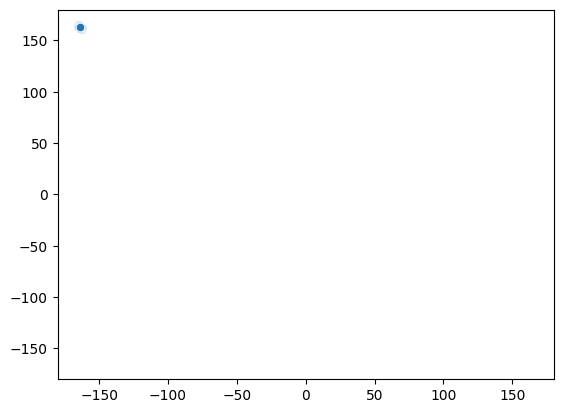

In [17]:
# print(samples)
rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[::1, :]])

In [18]:
L, eps

(Array(0.00196954, dtype=float64), Array(1.42137518e-05, dtype=float64))

In [21]:
nnp.mean(nnp.square(energy[1:]-energy[:-1])/math.prod(pos.shape))

Array(4.9211218e-05, dtype=float64)

In [18]:
(nnp.square(energy[1:]-energy[:-1])/math.prod(pos.shape)).mean()

Array(0.10941542, dtype=float64)

In [44]:
L, eps

(Array(0.02621379, dtype=float64), Array(0.02356748, dtype=float64))

In [32]:
from jax_md.simulate import AnnealingSampler

annealingsampler = AnnealingSampler(target, shift_fn=shift_fn)

# ...

In [71]:
samples.shape


(100, 2064)

In [24]:
# ## run nvt

from scipy.constants import k
key = jax.random.PRNGKey(0)

BOLTZMAN = 0.001987191
temperature = 300 * BOLTZMAN
dt = 1e-3
init, update = simulate.nvt_langevin(nlogp, shift_fn, dt, kT=temperature, gamma=0.1)
state = init(key, pos)
traj = []
# gs = []
# cs = []
for i in range(100000):
  if i%10==0:
    traj.append(state.position)
#     gs.append(jax.grad(lambda x : forces.compute(x, box))(state.position))
#     cs.append((lambda x : forces.compute(x, box))(state.position))
    
  state = update(state)
R = state.position
R

/opt/homebrew/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Array([[[11.049458 ,  7.793268 , 15.117361 ],
        [11.5900135,  7.5648136, 14.222508 ],
        [11.659822 ,  6.5127535, 14.030108 ],
        ...,
        [19.582058 ,  4.4552236, 13.451371 ],
        [18.621872 ,  4.869699 , 13.701062 ],
        [19.794624 ,  4.4379992, 14.476036 ]]], dtype=float32)

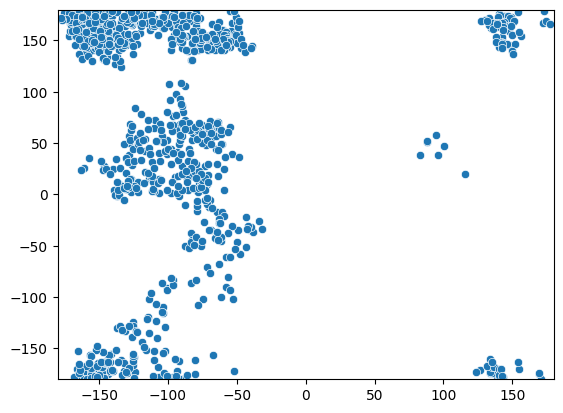

In [25]:
rama_plot(nnp.array(traj)[::10])
# nnp.array(traj).shape

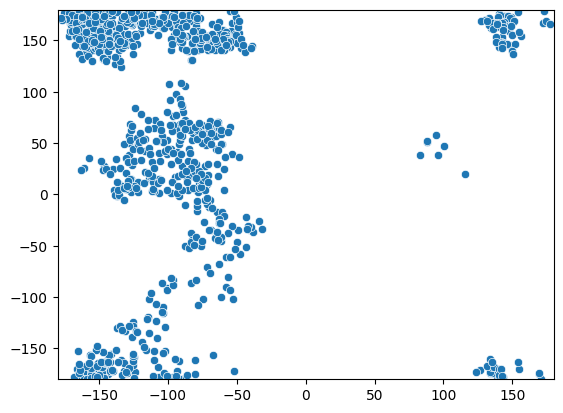

In [65]:
rama_plot(nnp.array(traj)[::10])
# nnp.array(traj).shape

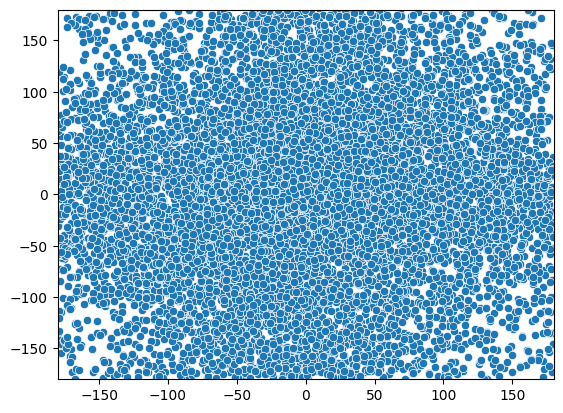

In [33]:
rama_plot(traj)